# **Phishing Email Classification using BERT**
This notebook demonstrates a **phishing email classification** model using a fine-tuned **BERT** (Bidirectional Encoder Representations from Transformers) model. The goal is to classify emails as either **phishing** or **not phishing** based on their subject and body content.

## **Workflow Overview**
1. **Load and preprocess data**: The dataset is loaded from a CSV file, and the email subject and body are combined for analysis.
2. **Dataset splitting**: The data is split into training, validation, and test sets.
3. **Model building**: A BERT-based model is fine-tuned using TensorFlow.
4. **Training and evaluation**: The model is trained on the dataset and performance is measured using accuracy, loss, confusion matrix and ROC-AUC score.
5. **Sample predictions**: The model is tested on a few sample emails to validate its phishing detection capability.


In [ ]:
!pip uninstall -y tensorflow tensorflow-text tf-models-official

In [ ]:
!pip install tensorflow[and-cuda]==2.15.*
!pip install tensorflow-text==2.15.*

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.15.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install tf-models-official==2.15.*

  Using cached tf_models_official-2.15.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tf_models_official-2.15.0-py2.py3-none-any.whl (2.7 MB)


##Imports

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##Load and Preprocess Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/emailphish/CEAS_08.csv')

df.info()

df = df[['subject', 'body', 'label']]
df.head(10)

df['text'] = df['subject'].astype(str) + " " + df['body'].astype(str)
df['label'] = df['label'].astype(int)

print("\nData shapes:")
print("Text shape:", df['text'].shape)
print("Label shape:", df['label'].shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB

Data shapes:
Text shape: (39154,)
Label shape: (39154,)


##Split Dataset

In [ ]:
BATCH_SIZE = 32
SEED = 42

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

# Function to create dataset
def create_dataset(texts, labels, batch_size):
    texts = tf.convert_to_tensor(texts.values, dtype=tf.string)
    labels = tf.convert_to_tensor(labels.values, dtype=tf.int32)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    dataset = dataset.shuffle(10000).batch(batch_size)
    return dataset

# Create datasets
train_ds = create_dataset(train_df['text'], train_df['label'], BATCH_SIZE)
val_ds = create_dataset(val_df['text'], val_df['label'], BATCH_SIZE)
test_ds = create_dataset(test_df['text'], test_df['label'], BATCH_SIZE)

# Verify dataset
for text_batch, label_batch in train_ds.take(1):
    print("\nSample batch shapes:")
    print("Text batch shape:", text_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Sample text:", text_batch[0].numpy().decode('utf-8')[:100])
    print("Sample label:", label_batch[0].numpy())



Sample batch shapes:
Text batch shape: (32,)
Label batch shape: (32,)
Sample text: 50 ways to meet your lover_jasmine123 ++++++++++++++++++++++++++++++
iGirl
50 years 0ld
I  l0oking f
Sample label: 1


##Load BERT Preprocessor and Encoder from TensorFlow Hub

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Test preprocessing layer
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
test_text = tf.constant(['Hello world'])
text_preprocessed = bert_preprocess(test_text)
print("\nPreprocessing test successful")


Preprocessing test successful


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

##Define Model Function and Hyperparameters

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)


##Train the Model

In [ ]:
history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
857/857 [==============================] - 239s 267ms/step - loss: 0.1149 - binary_accuracy: 0.9355 - val_loss: 0.0126 - val_binary_accuracy: 0.9969
Epoch 2/5
857/857 [==============================] - 229s 268ms/step - loss: 0.0105 - binary_accuracy: 0.9970 - val_loss: 0.0119 - val_binary_accuracy: 0.9974
Epoch 3/5
857/857 [==============================] - 231s 269ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 0.0150 - val_binary_accuracy: 0.9974
Epoch 4/5
857/857 [==============================] - 234s 273ms/step - loss: 5.6589e-04 - binary_accuracy: 0.9998 - val_loss: 0.0130 - val_binary_accuracy: 0.9978
Epoch 5/5
857/857 [==============================] - 249s 291ms/step - loss: 2.3841e-04 - binary_accuracy: 0.9999 - val_loss: 0.0137 - val_binary_accuracy: 0.9974


##Learning Curves


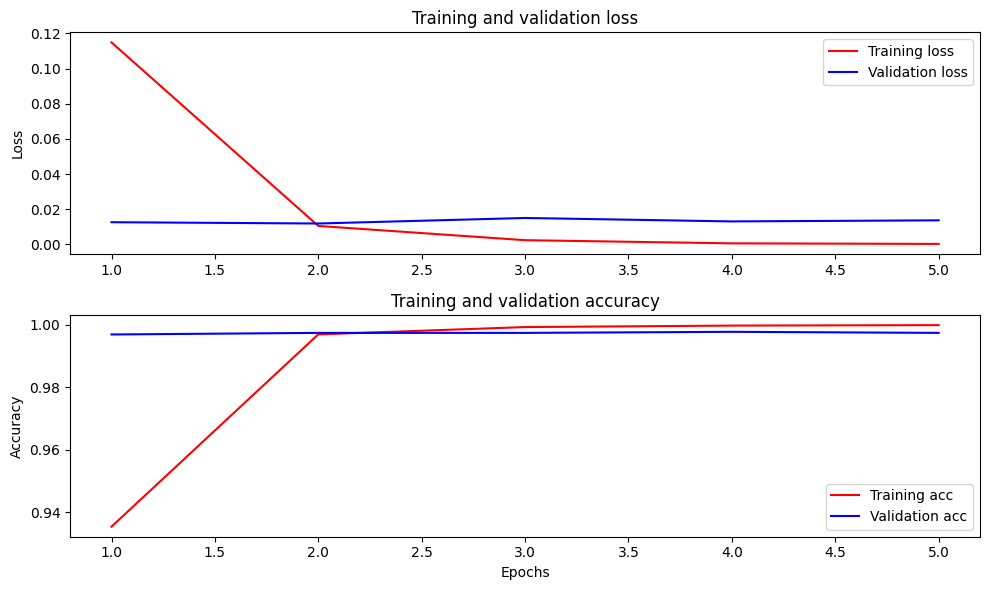

In [ ]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, 'r', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, 'r', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

##Evaluation

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

184/184 [==============================] - 30s 159ms/step - loss: 0.0147 - binary_accuracy: 0.9976
Loss: 0.01473322045058012
Accuracy: 0.9976165890693665


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Get true labels and predictions
y_true = []
y_pred = []

for text_batch, label_batch in test_ds:
    preds = classifier_model.predict(text_batch)
    preds = tf.sigmoid(preds).numpy().flatten()
    preds = (preds > 0.5).astype(int)  # Convert probabilities to binary predictions

    y_true.extend(label_batch.numpy())
    y_pred.extend(preds)

###Confusion Matrix

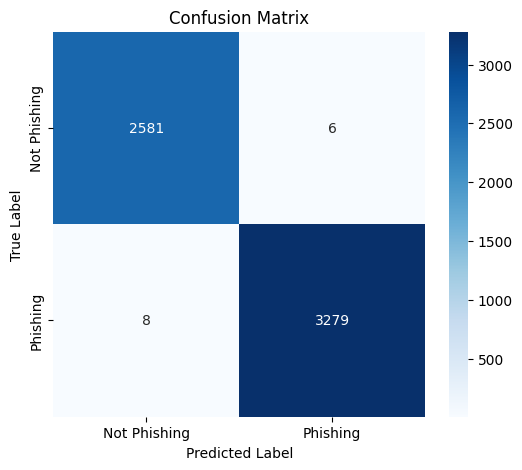

Classification Report:
               precision    recall  f1-score   support

Not Phishing       1.00      1.00      1.00      2587
    Phishing       1.00      1.00      1.00      3287

    accuracy                           1.00      5874
   macro avg       1.00      1.00      1.00      5874
weighted avg       1.00      1.00      1.00      5874

ROC-AUC Score: 0.9976


In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute classification report
class_report = classification_report(y_true, y_pred, target_names=['Not Phishing', 'Phishing'])
print("Classification Report:\n", class_report)

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

## Test Model with Sample Prediction

In [ ]:
def predict_examples(model, examples):
    results = tf.sigmoid(model(tf.constant(examples)))
    for i, result in enumerate(results):
        print(f'Text: {examples[i][:50]}...')
        print(f'Phishing probability: {result[0]:.4f}\n')

# Test examples
test_examples = [
    "Congratulations! You've won a free iPhone! Click here to claim your prize now!",
    "Meeting reminder: Team sync at 2 PM in the conference room",
    "URGENT: Your account has been compromised. Update your password immediately!",
    "Weekly project status update and next steps"
]

predict_examples(classifier_model, test_examples)

Text: Congratulations! You've won a free iPhone! Click h...
Phishing probability: 1.0000

Text: Meeting reminder: Team sync at 2 PM in the confere...
Phishing probability: 0.0000

Text: URGENT: Your account has been compromised. Update ...
Phishing probability: 1.0000

Text: Weekly project status update and next steps...
Phishing probability: 0.0005

